In [7]:
import meshio


def convert_med_to_xdmf(
    med_file,
    cell_file="mesh_domains.xdmf",
    facet_file="mesh_boundaries.xdmf",
    cell_type="tetra",
    facet_type="triangle",
):
    """Converts a MED mesh to XDMF
    Args:
        med_file (str): the name of the MED file
        cell_file (str, optional): the name of the file containing the
            volume markers. Defaults to "mesh_domains.xdmf".
        facet_file (str, optional): the name of the file containing the
            surface markers.. Defaults to "mesh_boundaries.xdmf".
        cell_type (str, optional): The topology of the cells. Defaults to "tetra".
        facet_type (str, optional): The topology of the facets. Defaults to "triangle".
    Returns:
        dict, dict: the correspondance dict, the cell types
    """
    msh = meshio.read(med_file)

    correspondance_dict = msh.cell_tags

    cell_data_types = msh.cell_data_dict["cell_tags"].keys()

    for mesh_block in msh.cells:
        if mesh_block.type == cell_type:

            meshio.write_points_cells(
                cell_file,
                msh.points,
                [mesh_block],
                cell_data={"f": [-1 * msh.cell_data_dict["cell_tags"][cell_type]]},
            )
        elif mesh_block.type == facet_type:
            meshio.write_points_cells(
                facet_file,
                msh.points,
                [mesh_block],
                cell_data={"f": [-1 * msh.cell_data_dict["cell_tags"][facet_type]]},
            )

    return correspondance_dict, cell_data_types

In [8]:
mesh_file = "../challenge_D/challenge_mesh.med"

correspondance_dict, cell_data_types = convert_med_to_xdmf(
    mesh_file,
    cell_type="triangle",
    facet_type="line",
    cell_file="../challenge_D/mesh_domains.xdmf",
    facet_file="../challenge_D/mesh_boundaries.xdmf",
)

print("This is the correspondance dict:")
print(correspondance_dict)

This is the correspondance dict:
{-6: ['solid'], -7: ['inner_boundary'], -8: ['outer_boundary']}


In [14]:
import festim as F
import h_transport_materials as htm

# IDs for volumes and surfaces (must be the same as in xdmf files)

id_solid = 6

id_inner_boundary = 7
id_outer_boundary = 8

my_model = F.Simulation(log_level=40)

# define mesh
my_model.mesh = F.MeshFromXDMF(
    volume_file="../challenge_D/mesh_domains.xdmf",
    boundary_file="../challenge_D/mesh_boundaries.xdmf",
)

# material properties
D_mat = htm.diffusivities.filter(material="gold")[0]

D_0 = D_mat.pre_exp.magnitude
E_D = D_mat.pre_exp.magnitude

my_mat = F.Material(
    id=id_solid, D_0=D_0, E_D=E_D
)
my_model.materials = F.Materials([my_mat])

# define temperature
my_model.T = F.Temperature(value=500)

# define boundary conditions
my_model.boundary_conditions = [
    F.ImplantationDirichlet(
        surfaces=id_inner_boundary,
        phi=1e19,
        R_p=3e-09,
        D_0=D_0,
        E_D=E_D,
    ),
    F.RecombinationFlux(surfaces=id_outer_boundary, Kr_0=1.4e-26,E_Kr=-0.25, order=2),
]

# define exports
my_derived_quantities = F.DerivedQuantities(
    [F.SurfaceFlux("solute", surface=2)],
    show_units=True,
)
my_model.exports = F.Exports([F.XDMFExport("solute", folder="../challenge_D/", mode=1)])

my_model.dt = F.Stepsize(
    initial_value=1,
    stepsize_change_ratio=1.05,
    stepsize_stop_max=1 / 10,
    dt_min=1e-04, 
    t_stop=1e09
)

my_model.settings = F.Settings(
    transient=True,
    maximum_iterations=30,
    final_time=1e6,
    absolute_tolerance=1e-10,
    relative_tolerance=1e-10,
)

my_model.initialise()
my_model.run()

Succesfully load mesh with 17641 cells
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/jdark/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/stepsize.py:54: DeprecationWarning: stepsize_stop_max and t_stop attributes will be deprecated in a future release, please use max_stepsize instead
  warnings.warn(


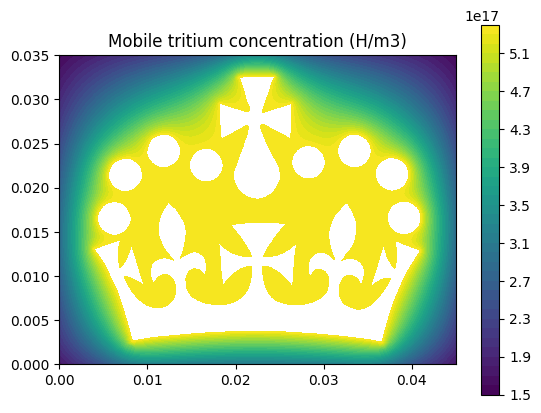

In [10]:
import fenics as f
import matplotlib.pyplot as plt

surface_flux = np.abs(my_derived_quantities[0].data[0])

print(f"Surface flux = {surface_flux:.2e} H/m2/s")



sol = my_model.h_transport_problem.mobile.mobile_concentration()
CS = f.plot(sol)

plt.colorbar(CS)
plt.title("Mobile tritium concentration (H/m3)")
plt.show()